# Aligning single-cell resolution spatial transcriptomics data to  H&E staining image from Visium


In this notebook, we take a single cell resolution spatial transcriptomics datasets of a coronal section of the adult mouse brain profiled by the MERFISH technology and align it to a H&E staining image from a different individual at matched locations with respect to bregma. 

We will use `STalign` to achieve this alignment. We will first load the relevant code libraries.

In [2]:
## import dependencies
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.transforms as mtransforms
import pandas as pd
import torch
import plotly
import requests

# make plots bigger
plt.rcParams["figure.figsize"] = (12,10)

In [2]:
# OPTION A: import STalign after pip or pipenv install
#from STalign import STalign

In [3]:
## OPTION B: skip cell if installed STalign with pip or pipenv
import sys
sys.path.append("../../STalign") 

## import STalign from upper directory
import STalign

We can read in the single cell information using `pandas` as `pd`.

In [4]:
# Single cell data 1
# read in data
fname = '../merfish_data/datasets_mouse_brain_map_BrainReceptorShowcase_Slice2_Replicate3_cell_metadata_S2R3.csv.gz'
df1 = pd.read_csv(fname)
print(df1.head())

                                Unnamed: 0  fov       volume    center_x   
0  158338042824236264719696604356349910479   33   532.778772  617.916619  \
1  260594727341160372355976405428092853003   33  1004.430016  596.808018   
2  307643940700812339199503248604719950662   33  1267.183208  578.880018   
3   30863303465976316429997331474071348973   33  1403.401822  572.616017   
4  313162718584097621688679244357302162401   33   507.949497  608.364018   

      center_y       min_x       max_x        min_y        max_y  
0  2666.520010  614.725219  621.108019  2657.545209  2675.494810  
1  2763.450012  589.669218  603.946818  2757.013212  2769.886812  
2  2748.978012  570.877217  586.882818  2740.489211  2757.466812  
3  2766.690012  564.937217  580.294818  2756.581212  2776.798812  
4  2687.418010  603.061218  613.666818  2682.493210  2692.342810  


For alignment with `STalign`, we only need the cell centroid information. So we can pull out this information. We can further visualize the cell centroids to get a sense of the variation in cell density that we will be relying on for our alignment by plotting using `matplotlib.pyplot` as `plt`. 

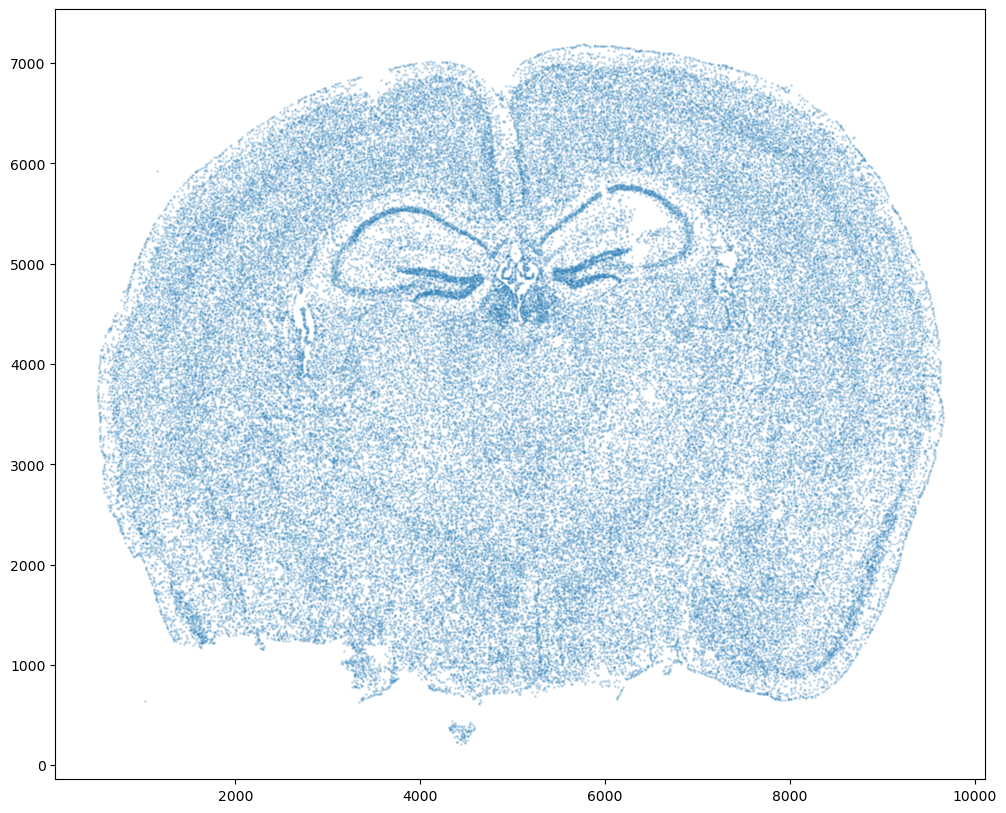

In [5]:
# get cell centroid coordinates
xI = np.array(df1['center_x'])
yI = np.array(df1['center_y'])

# plot
fig,ax = plt.subplots()
ax.scatter(xI,yI,s=1,alpha=0.2)
#ax.set_aspect('equal', 'box')

In [6]:
import numpy as np
fname = '../visium_data/tissue_hires_image_points.npy'
data2 = np.load(fname, allow_pickle=True)

We will use STalign to rasterize the single cell centroid positions into an image. Assuming the single-cell centroid coordinates are in microns, we will perform this rasterization at a 30 micron resolution. We can visualize the resulting rasterized image.

Note that points are plotting with the origin at bottom left while images are typically plotted with origin at top left so we've used `invert_yaxis()` to invert the yaxis for visualization consistency.

0 of 85958
10000 of 85958
20000 of 85958
30000 of 85958
40000 of 85958
50000 of 85958
60000 of 85958
70000 of 85958
80000 of 85958
85957 of 85958


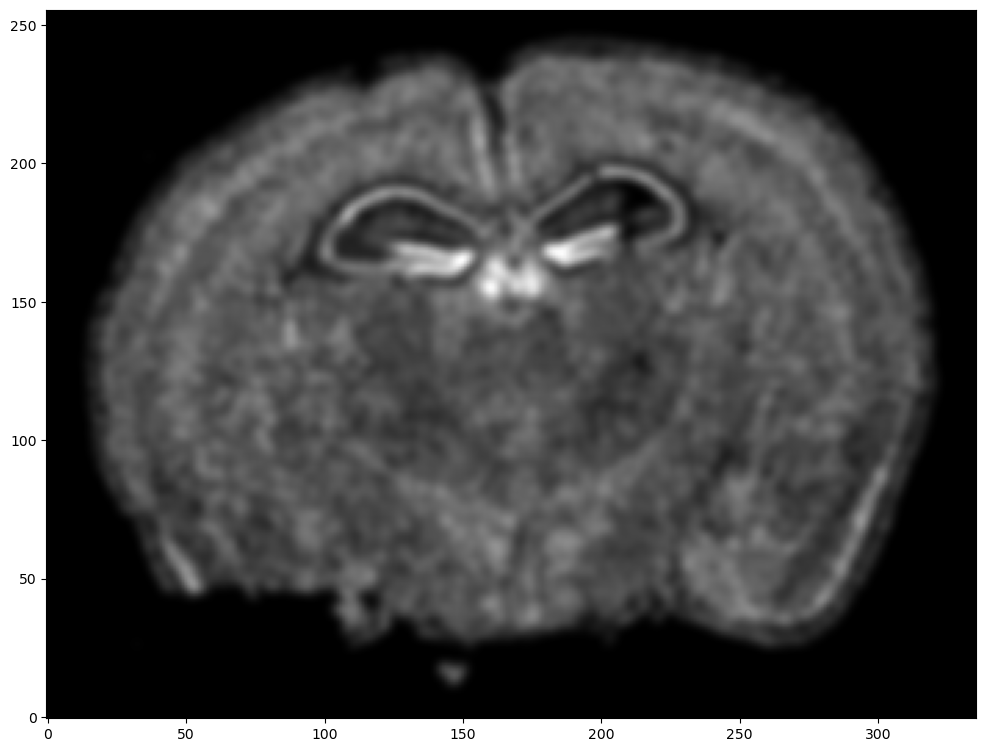

In [7]:
# rasterize at 30um resolution (assuming positions are in um units) and plot
XI,YI,I,fig = STalign.rasterize(xI, yI, dx=30)

ax = fig.axes[0]
ax.invert_yaxis()

In [10]:
YI.shape
I.shape

(1, 256, 336)

0 of 85958
10000 of 85958
20000 of 85958
30000 of 85958
40000 of 85958
50000 of 85958
60000 of 85958
70000 of 85958
80000 of 85958
85957 of 85958


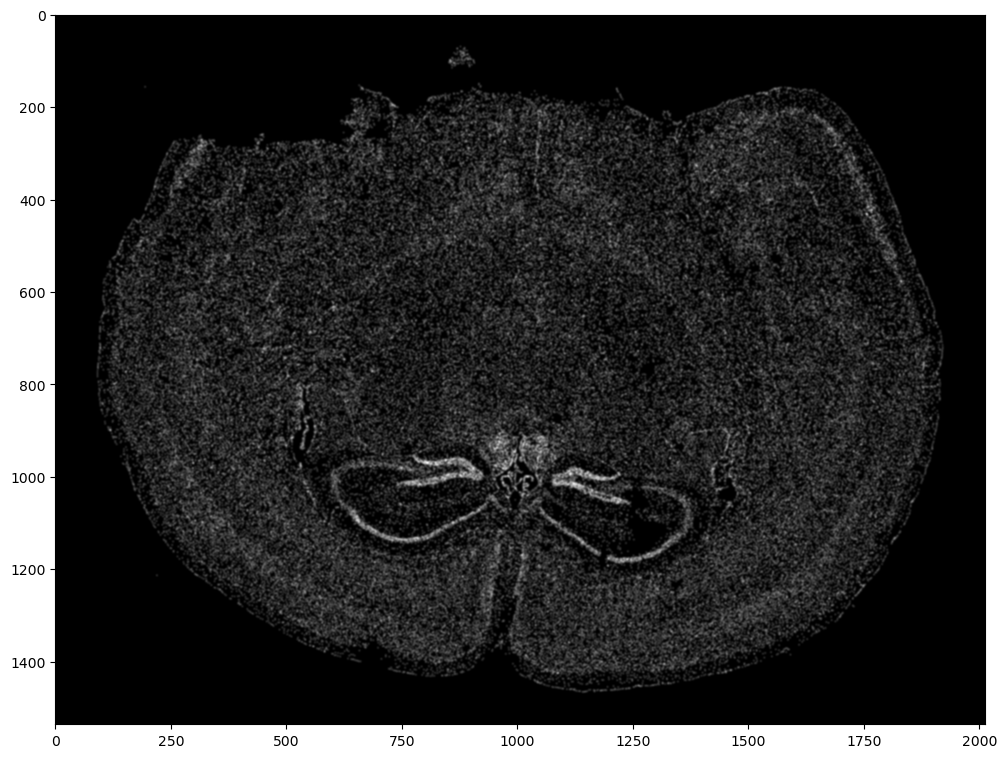

In [8]:
dx=5
blur = 1
X_,Y_,W_,fig  = STalign.rasterize(xI, yI,dx=dx)     

Text(0.5, 1.0, 'Rasterized')

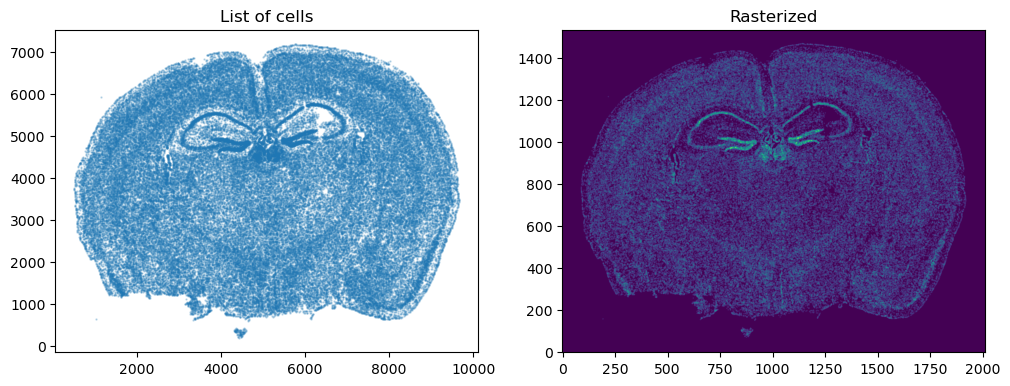

In [9]:
#Plot unrasterized/rasterized images

#mlp.rcParams['figure.dpi'] = 1000
#mlp.rcParams['savefig.dpi'] = 1000

fig,ax = plt.subplots(1,2)
ax[0].scatter(xI, yI,s=0.5,alpha=0.25)
#ax[0].invert_yaxis()

ax[0].set_title('List of cells')
ax[0].set_aspect('equal')

W = W_[0]
extent = (X_[0],X_[-1],Y_[0],Y_[-1])    
ax[1].imshow(W,  origin='lower') 
#ax[1].invert_yaxis()    
ax[1].set_title('Rasterized')


Note that this is a 1D greyscale image. To align with an RGB H&E image, we will need to make our greyscale image into RGB by simply stacking the 1D values 3 times. We will also normalize to get intensity values between 0 to 1.

In [10]:
print("The initial shape of I is {}".format(I.shape))
I = np.vstack((I, I, I)) # make into 3xNxM
print("The range of I is {} to {}".format(I.min(), I.max() ))

# normalize
I = STalign.normalize(I)
print("The range of I after normalization is {} to {}".format(I.min(), I.max() ))

# double check size of things
print("The new shape of I is {}".format(I.shape))

The initial shape of I is (1, 256, 336)
The range of I is 0.0 to 4.715485184477206
The range of I after normalization is 0.0 to 1.0
The new shape of I is (3, 256, 336)


We have already downloaded the H&E staining image from https://www.10xgenomics.com/resources/datasets/adult-mouse-brain-ffpe-1-standard-1-3-0 and placed the file in a folder called `visium_data`

We can read in the H&E staining image using `matplotlib.pyplot` as `plt`. 

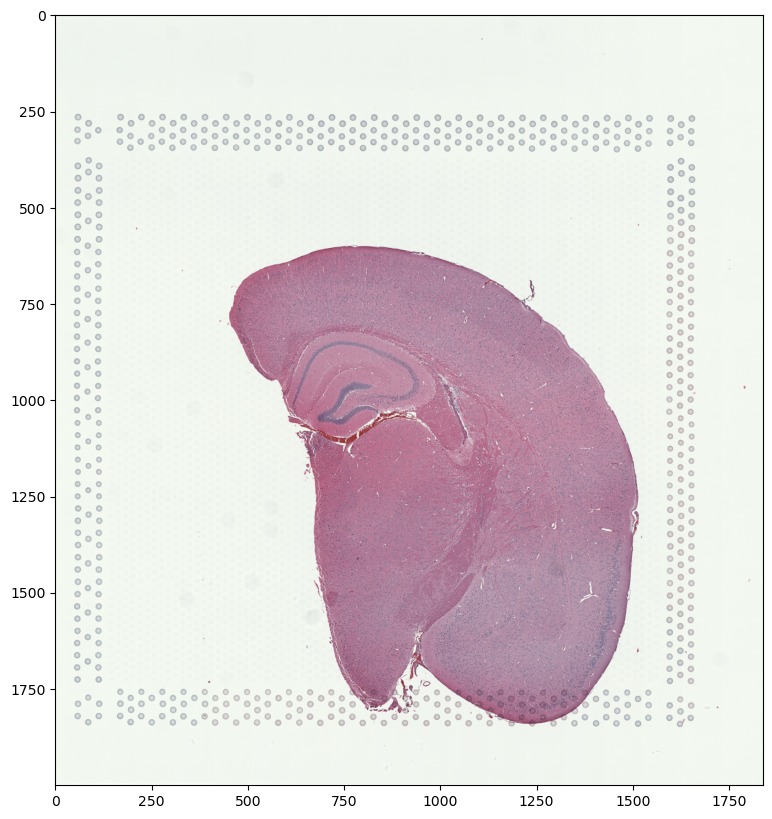

In [11]:
image_file = '../visium_data/tissue_hires_image.png'
V = plt.imread(image_file)

# plot
fig,ax = plt.subplots()
ax.imshow(V)

Note that this is an RGB image that `matplotlib.pyplot` had read in as an NxMx3 matrix with values ranging from 0 to 1. We will use `STalign` to normalize the image in case there are any outlier intensities. 

In [12]:
print("The initial shape of V is {}".format(V.shape))
print("The range of V is {} to {}".format(V.min(), V.max() ))

Vnorm = STalign.normalize(V)
print("The range of V after normalization is {} to {}".format(Vnorm.min(), Vnorm.max() ))

The initial shape of V is (2000, 1838, 3)
The range of V is 0.10588235408067703 to 1.0
The range of V after normalization is 0.0 to 1.0


We will transpose `Vnorm` to be a 3xNxM matrix `J` for downstream analyses. We will also create some variances `YJ` and `XJ` to keep track of the image size. 

In [13]:
J = Vnorm.transpose(2,0,1)
print("The new shape of J is {}".format(J.shape))

YJ = np.array(range(J.shape[1]))*1. # needs to be longs not doubles for STalign.transform later so multiply by 1.
XJ = np.array(range(J.shape[2]))*1. # needs to be longs not doubles for STalign.transform later so multiply by 1.

The new shape of J is (3, 2000, 1838)


We now have a rasterized image corresponding to the single cell positions from the spatial transcriptomics data and an H&E image that we can align. Note, that we have specified the image from cell positions as source `I` and the H&E image as target `J` because the H&E image is only one hemisphere of the brain. We advise choosing the more complete tissue section as the source such that every observation in the target has some correspondence in the source.

Text(0.5, 1.0, 'target')

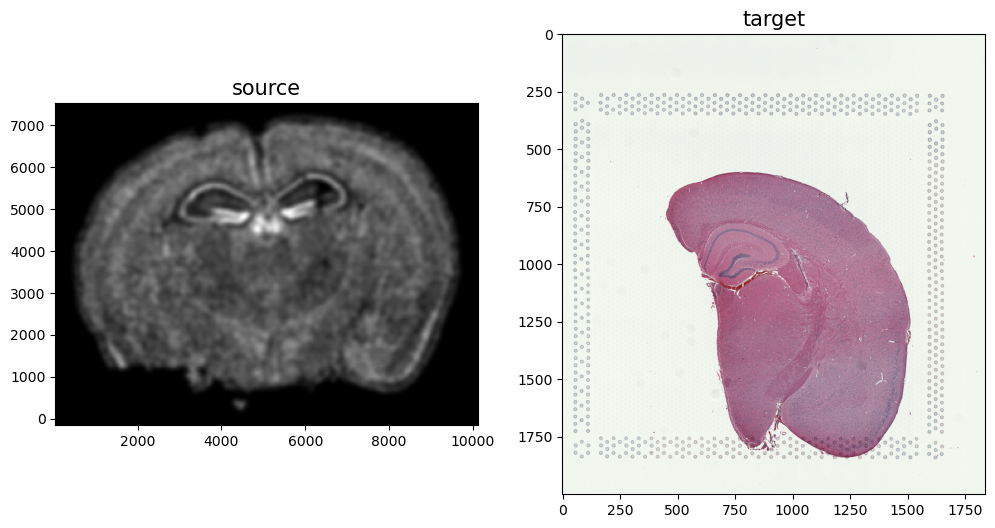

In [14]:
# plot

# get extent of images
extentJ = STalign.extent_from_x((YJ,XJ))
extentI = STalign.extent_from_x((YI,XI))

fig,ax = plt.subplots(1,2)
ax[0].imshow((I.transpose(1,2,0).squeeze()), extent=extentI) 
ax[0].invert_yaxis()
ax[0].set_title('source', fontsize=15)
ax[1].imshow((J.transpose(1,2,0).squeeze()), extent=extentJ)
ax[1].set_title('target', fontsize=15)

In [15]:
np.savez('../visium_data/Merfish_S2_R3', x=XI,y=YI,I=I)
np.savez('../visium_data/tissue_hires_image', x=XJ,y=YJ,I=J)

Because we desire a partial matching, we incorporated manually placed landmarks to initialize the alignment and further help steer our gradient descent towards an appropriate solution.  A `point_annotator.py` script is provided to assist with this. In order to use the `point_annotator.py` script, we will need to write out our images as `.npz` files. 

Given these `.npz` files, we can then run the following code on the command line from inside the `notebooks` folder:

```
python ../../STalign/point_annotator.py ../visium_data/Merfish_S2_R3.npz ../visium_data/tissue_hires_image.npz
```

Which will provide a graphical user interface (GUI) to selecting points. Once you run the code, the command line will prompt you to enter the name of a landmark point. Then, you will be prompted on the GUI to select and save the landmark point for both source and target images. You can annotate multiple landmark points with the same name, and each of them would have an index at the end (e.g. "CA0" and "CA1" in this tutorial). However, when doing so, make sure to annotate landmark points alternatively on source and target to avoid any error. You can annotate multiple landmark points with different names by repeating the process of entering the name for a landmark point, following the GUI prompts, and returning to the command line to enter the name for the next landmark point.

Annotated points will saved as `Merfish_S2_R3_points.npy` and `tissue_hires_image_points.npy` respectively. We can then read in these files. 

In [15]:
# read from file
pointsIlist = np.load('../visium_data/Merfish_S2_R3_points.npy', allow_pickle=True).tolist()
print(pointsIlist)
pointsJlist = np.load('../visium_data/tissue_hires_image_points.npy', allow_pickle=True).tolist()
print(pointsJlist)

{'RSP': [(5095.02260152, 5499.7972588), (4910.8223317, 6628.02391148), (5463.42314117, 7019.44948485)], 'DG-sg': [(5532.49824236, 4901.14638187), (6131.14911929, 4832.07128069), (6223.2492542, 5131.39671915)], 'CA': [(5371.32300626, 5269.54692152), (6154.17415302, 5753.07262981), (6683.74992876, 5591.89739371), (6937.02529977, 5246.52188779)], 'PAA': [(8111.3020199, 641.51514218)], 'MEAav': [(6937.02529977, 963.86561437)], 'test': [(7977.306518209469, 3624.998941577942), (6001.103292403017, 2363.086038352136)]}
{'RSP': [(559.82404846, 938.72950082), (463.88640793, 788.82693749), (505.85912566, 674.90098936)], 'DG-sg': [(709.72661179, 1046.65934642), (823.65255993, 1022.67493629), (799.66814979, 956.71780842)], 'CA': [(631.77727886, 1016.67883376), (733.71102193, 860.78016789), (859.62917513, 878.76847549), (949.57071313, 962.71391096)], 'PAA': [(1267.3641474, 1826.15267576)], 'MEAav': [(955.56681566, 1694.23842003)], 'test': [(1250.5258064516138, 1060.3713978494627), (1146.174838709678

Note that these landmark points are read in as lists. We will want to convert them to a simple array for downstream usage. 

In [16]:
# convert to array
pointsI = []
pointsJ = []

for i in pointsIlist.keys():
    for j in range(len(pointsIlist[i])):
        pointsI.append([pointsIlist[i][j][1], pointsIlist[i][j][0]])
for i in pointsJlist.keys():
    for j in range(len(pointsJlist[i])):
        pointsJ.append([pointsJlist[i][j][1], pointsJlist[i][j][0]])
    
pointsI = np.array(pointsI)
pointsJ = np.array(pointsJ)

In [17]:
# now arrays
print(pointsI)
print(pointsJ)

[[5499.7972588  5095.02260152]
 [6628.02391148 4910.8223317 ]
 [7019.44948485 5463.42314117]
 [4901.14638187 5532.49824236]
 [4832.07128069 6131.14911929]
 [5131.39671915 6223.2492542 ]
 [5269.54692152 5371.32300626]
 [5753.07262981 6154.17415302]
 [5591.89739371 6683.74992876]
 [5246.52188779 6937.02529977]
 [ 641.51514218 8111.3020199 ]
 [ 963.86561437 6937.02529977]
 [3624.99894158 7977.30651821]
 [2363.08603835 6001.1032924 ]]
[[ 938.72950082  559.82404846]
 [ 788.82693749  463.88640793]
 [ 674.90098936  505.85912566]
 [1046.65934642  709.72661179]
 [1022.67493629  823.65255993]
 [ 956.71780842  799.66814979]
 [1016.67883376  631.77727886]
 [ 860.78016789  733.71102193]
 [ 878.76847549  859.62917513]
 [ 962.71391096  949.57071313]
 [1826.15267576 1267.3641474 ]
 [1694.23842003  955.56681566]
 [1060.37139785 1250.52580645]
 [1577.77827957 1146.17483871]]


We can double check that our landmark points look sensible by plotting them along with the rasterized image we created.

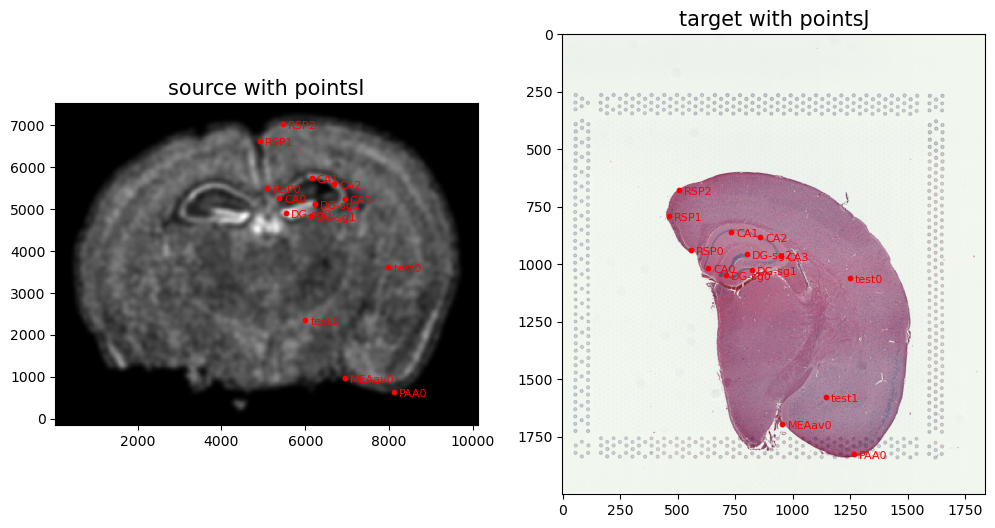

In [18]:
# plot

fig,ax = plt.subplots(1,2)
ax[0].imshow((I.transpose(1,2,0).squeeze()), extent=extentI) 
ax[1].imshow((J.transpose(1,2,0).squeeze()), extent=extentJ)

trans_offset_0 = mtransforms.offset_copy(ax[0].transData, fig=fig,
                                       x=0.05, y=-0.05, units='inches')
trans_offset_1 = mtransforms.offset_copy(ax[1].transData, fig=fig,
                                       x=0.05, y=-0.05, units='inches')

ax[0].scatter(pointsI[:,1],pointsI[:,0], c='red', s=10)
ax[1].scatter(pointsJ[:,1],pointsJ[:,0], c='red', s=10)
    
for i in pointsIlist.keys():
    for j in range(len(pointsIlist[i])):
        ax[0].text(pointsIlist[i][j][0], pointsIlist[i][j][1],f'{i}{j}', c='red', transform=trans_offset_0, fontsize= 8)
for i in pointsJlist.keys():
    for j in range(len(pointsJlist[i])):
        ax[1].text(pointsJlist[i][j][0], pointsJlist[i][j][1],f'{i}{j}', c='red', transform=trans_offset_1, fontsize= 8)
        
ax[0].set_title('source with pointsI', fontsize=15)
ax[1].set_title('target with pointsJ', fontsize=15)

# invert only rasterized image
ax[0].invert_yaxis()

From the landmark points, we can generate a linear transformation `L` and translation `T` which will produce a simple initial affine transformation `A`. 

In [19]:
# set device for building tensors
if torch.cuda.is_available():
    torch.set_default_device('cuda:0')
else:
    torch.set_default_device('cpu')

In [20]:
# compute initial affine transformation from points
L,T = STalign.L_T_from_points(pointsI,pointsJ)
A = STalign.to_A(torch.tensor(L),torch.tensor(T))

In [1]:
XI

NameError: name 'XI' is not defined

We can show the results of the simple affine transformation.

/home/albert/anaconda3/lib/python3.11/site-packages/torch/utils/_device.py:78: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return func(*args, **kwargs)


Text(0.5, 1.0, 'target')

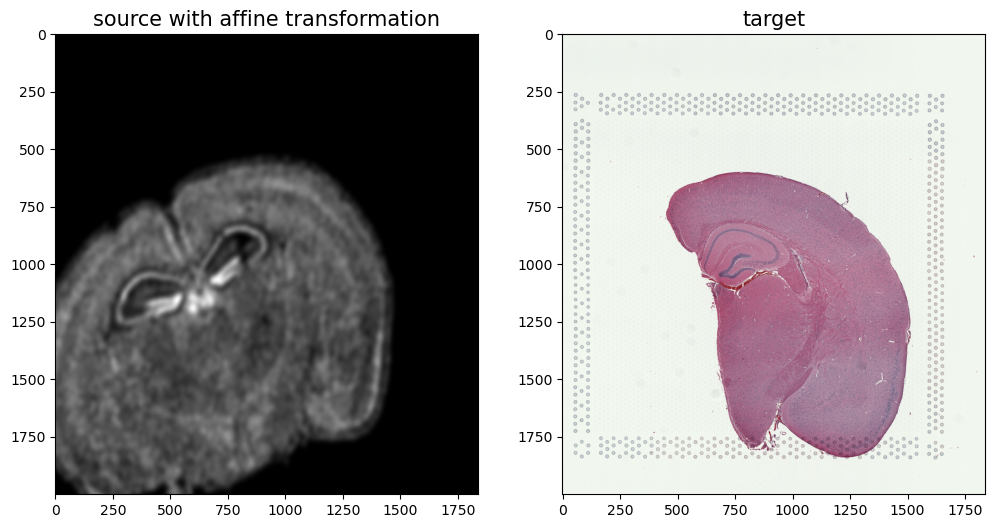

In [22]:
# compute initial affine transformation from points
AI= STalign.transform_image_source_with_A(A, [YI,XI], I, [YJ,XJ])

#switch tensor from cuda to cpu for plotting with numpy
if AI.is_cuda:
    AI = AI.cpu()

fig,ax = plt.subplots(1,2)

ax[0].imshow((AI.permute(1,2,0).squeeze()), extent=extentJ) 
ax[1].imshow((J.transpose(1,2,0).squeeze()), extent=extentJ) 

ax[0].set_title('source with affine transformation', fontsize=15)
ax[1].set_title('target', fontsize=15)

Text(0.5, 1.0, 'Landmark-based Affine Alignment')

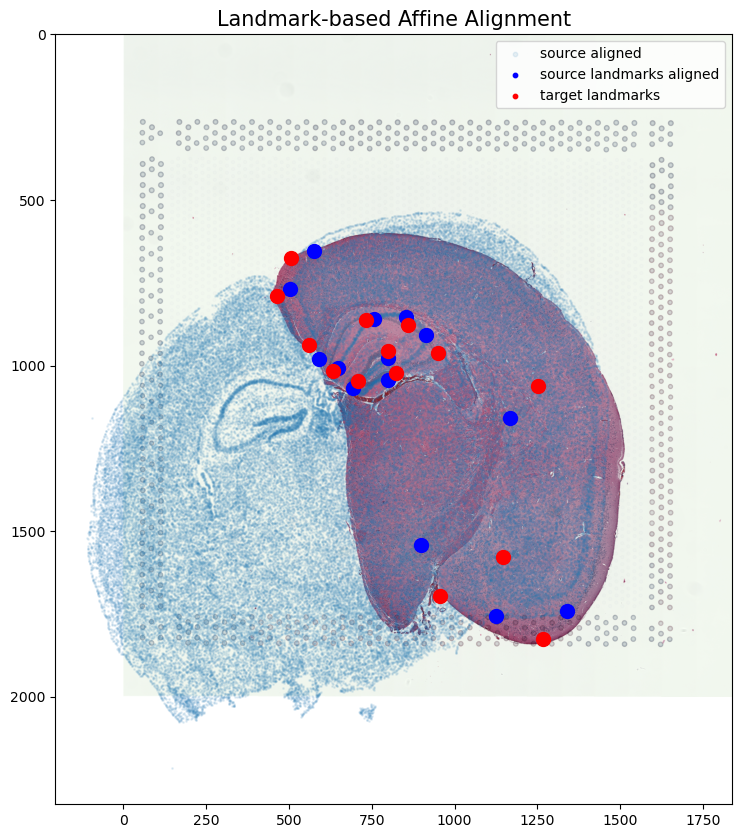

In [24]:
#apply A to sources points in row, column (y,x) orientation
affine = np.matmul(np.array(A.cpu()),np.array([yI, xI, np.ones(len(xI))]))

xIaffine = affine[1,:] 
yIaffine = affine[0,:]


#apply A to sources landmark points in row, column (y,x) orientation
ypointsI = pointsI[:,0]
xpointsI = pointsI[:,1]
affine = np.matmul(np.array(A.cpu()),np.array([ypointsI, xpointsI, np.ones(len(ypointsI))]))

xpointsIaffine = affine[1,:] 
ypointsIaffine = affine[0,:]
pointsIaffine = np.column_stack((ypointsIaffine,xpointsIaffine))


# plot results
fig,ax = plt.subplots()

ax.imshow((J).transpose(1,2,0),extent=extentJ)

ax.scatter(xIaffine,yIaffine,s=1,alpha=0.1, label = 'source aligned')
ax.scatter(pointsIaffine[:,1],pointsIaffine[:,0],c="blue", label='source landmarks aligned', s=100)
    
ax.scatter(pointsJ[:,1],pointsJ[:,0], c='red', label='target landmarks', s=100)
ax.set_aspect('equal')

lgnd = plt.legend(loc="upper right", scatterpoints=1, fontsize=10)
for handle in lgnd.legend_handles:
    handle.set_sizes([10.0])
    
ax.set_title('Landmark-based Affine Alignment', fontsize=15)

In [25]:
yI

array([2666.52000953, 2763.45001205, 2748.97801167, ..., 4187.26807321,
       4208.81933772, 4219.01993798])

In [33]:
J.shape

(3, 2000, 1838)

: 

In this case, we can observe that a simple affine alignment is not sufficient to align the single-cell spatial transcriptomics dataset to the H&E staining image. So we will need to perform non-linear local alignments via LDDMM.

/home/albert/anaconda3/lib/python3.11/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3483.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
/home/albert/Documentos/GitHub/STalign/docs/notebooks/../../STalign/STalign.py:1301: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  axE[2].set_yscale('log')


CPU times: user 30min 46s, sys: 8min 52s, total: 39min 38s
Wall time: 12min 57s


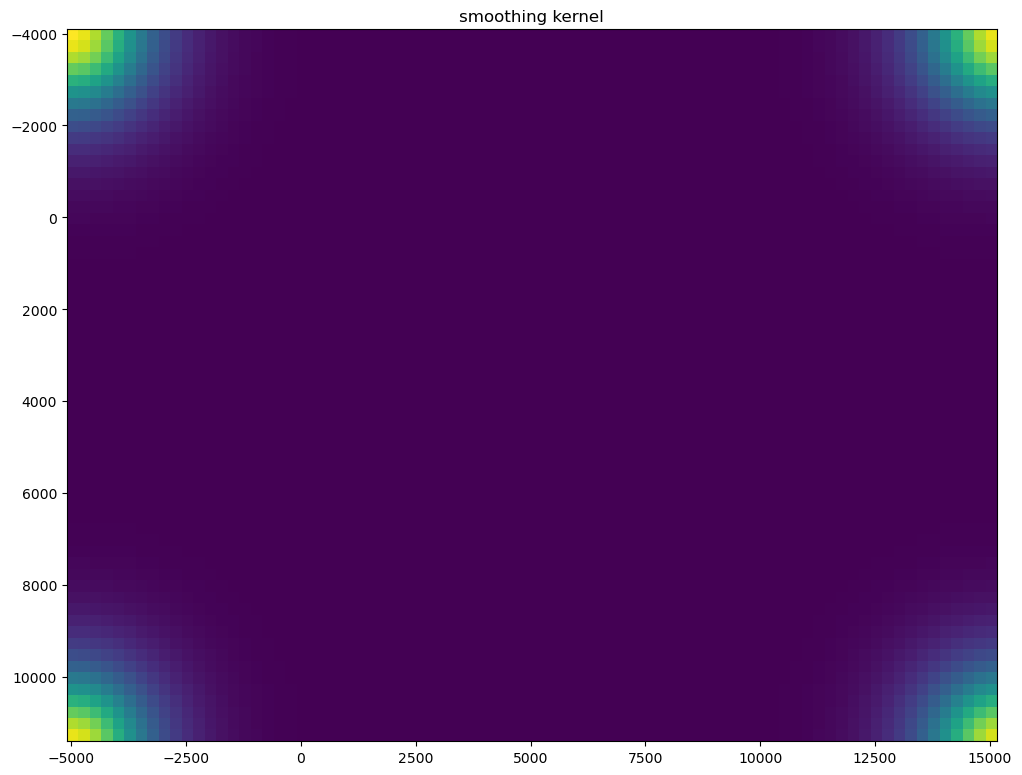

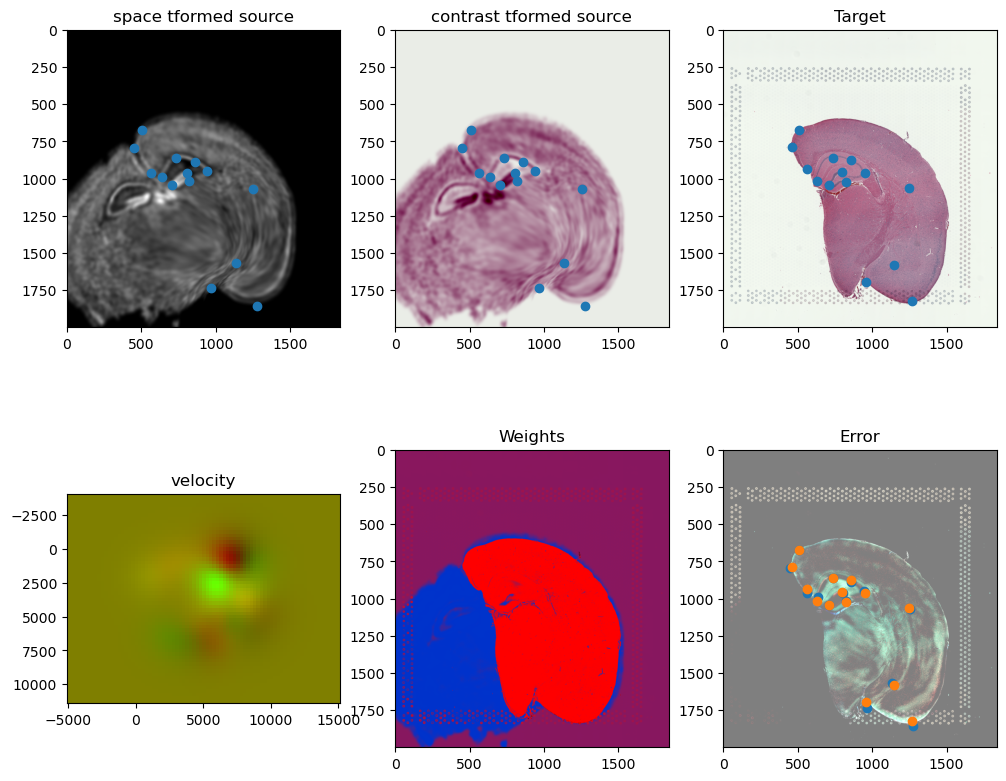

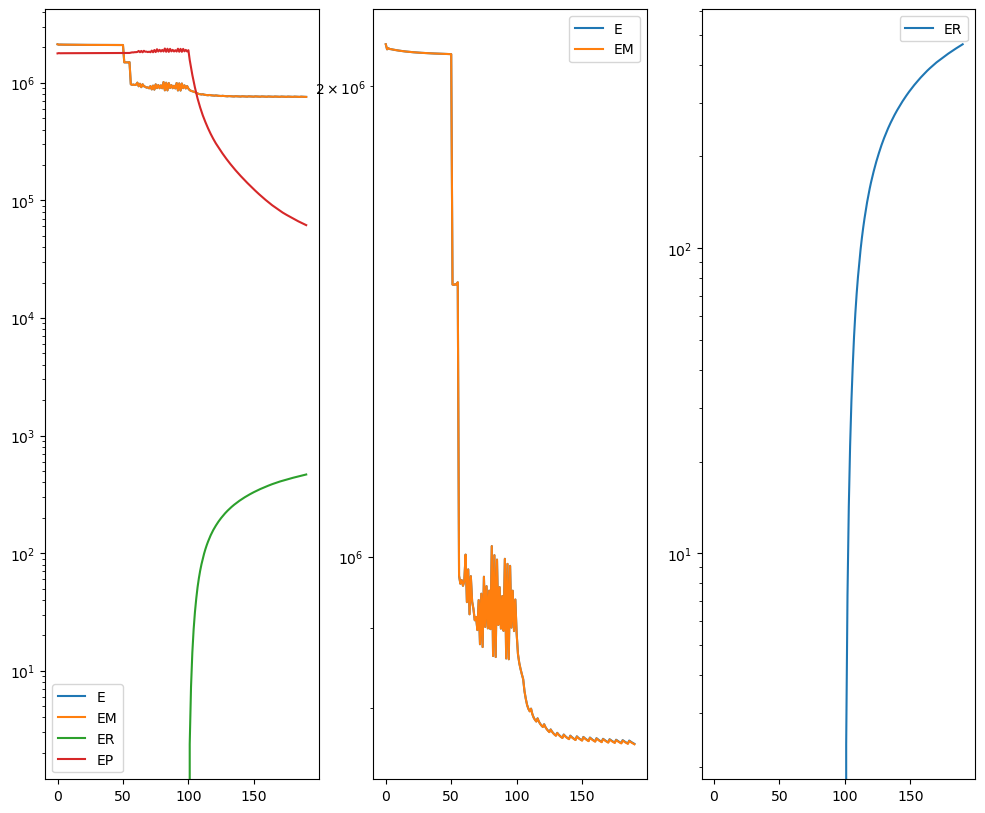

In [25]:
%%time

# run LDDMM
# specify device (default device for STalign.LDDMM is cpu)
if torch.cuda.is_available():
    device = 'cuda:0'
else:
    device = 'cpu'

# keep all other parameters default
params = {'L':L,'T':T,
          'niter': 200,
          'pointsI': pointsI,
          'pointsJ': pointsJ,
          'device': device,
          'sigmaP': 2e-1,
          'sigmaM': 0.18,
          'sigmaB': 0.18, 
          'sigmaA': 0.18,
          'diffeo_start' : 100,
          'epL': 5e-11,
          'epT': 5e-4,
          'epV': 5e1
          }

out = STalign.LDDMM([YI,XI],I,[YJ,XJ],J,**params)

In [26]:
#### get necessary output variables
A = out['A']
v = out['v']
xv = out['xv']
WM = out['WM']

Plots generated throughout the alignment can be used to give you a sense of whether the parameter choices are appropriate and whether your alignment is converging on a solution.

We can also evaluate the resulting alignment by applying the transformation to visualize how our source and target images were deformed to achieve the alignment. 

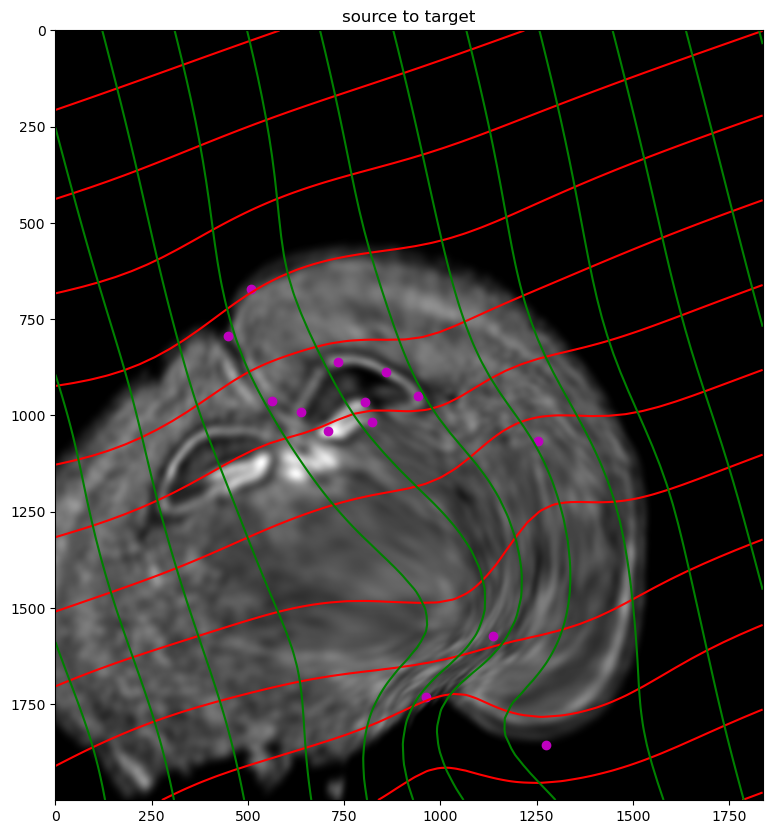

In [27]:
# apply transform
phii = STalign.build_transform(xv,v,A,XJ=[YJ,XJ],direction='b')
phiI = STalign.transform_image_source_to_target(xv,v,A,[YI,XI],I,[YJ,XJ])
phiipointsI = STalign.transform_points_source_to_target(xv,v,A,pointsI)

#switch tensor from cuda to cpu for plotting with numpy
if phii.is_cuda:
    phii = phii.cpu()
if phiI.is_cuda:
    phiI = phiI.cpu()
if phiipointsI.is_cuda:
    phiipointsI = phiipointsI.cpu()


# plot with grids
fig,ax = plt.subplots()
levels = np.arange(-100000,100000,1000)

ax.contour(XJ,YJ,phii[...,0],colors='r',linestyles='-',levels=levels)
ax.contour(XJ,YJ,phii[...,1],colors='g',linestyles='-',levels=levels)
ax.set_aspect('equal')
ax.set_title('source to target')

ax.imshow(phiI.permute(1,2,0)/torch.max(phiI),extent=extentJ)
ax.scatter(phiipointsI[:,1].detach(),phiipointsI[:,0].detach(),c="m")

Finally, we can apply our transform to the original sets of single cell centroid positions to achieve their new aligned positions.

In [ ]:
# apply transform to original points
tpointsI= STalign.transform_points_source_to_target(xv,v,A, np.stack([yI, xI], 1))

#switch tensor from cuda to cpu for plotting with numpy
if tpointsI.is_cuda:
    tpointsI = tpointsI.cpu()

# switch from row column coordinates (y,x) to (x,y)
xI_LDDMM = tpointsI[:,1]
yI_LDDMM = tpointsI[:,0]

And we can visualize the results.

In [ ]:
# plot results
fig,ax = plt.subplots()

ax.imshow((J).transpose(1,2,0),extent=extentJ)

ax.scatter(xI_LDDMM,yI_LDDMM,s=1,alpha=0.1, label = 'source aligned')
ax.scatter(phiipointsI[:,1].detach(),phiipointsI[:,0].detach(),c="blue", label='source landmarks aligned', s=100)
    
ax.scatter(pointsJ[:,1],pointsJ[:,0], c='red', label='target landmarks', s=100)
ax.set_aspect('equal')

lgnd = plt.legend(loc="upper right", scatterpoints=1, fontsize=10)
for handle in lgnd.legend_handles:
    handle.set_sizes([10.0])
    
ax.set_title('After alignment aligned source and target with aligned pointsI and pointsJ', fontsize=15)

Reminder of what source and target looked like before alignment

In [ ]:
# plot
fig,ax = plt.subplots()
ax.scatter(xI,yI,s=1,alpha=0.2)
ax.set_aspect('equal', 'box')
ax.scatter(pointsI[:,1],pointsI[:,0], c='blue', s=100)
ax.set_title('Before alignment: source with pointsI', fontsize=15)

In [ ]:
fig,ax = plt.subplots()
ax.imshow((J.transpose(1,2,0).squeeze()), extent=extentJ)
ax.scatter(pointsJ[:,1],pointsJ[:,0], c='red', s=100)
ax.set_title('Before alignment: target with pointsJ', fontsize=15)

Save the new aligned positions by appending to our original data

In [ ]:
if tpointsI.is_cuda:
    df3 = pd.DataFrame(

        {

            "aligned_x": xI_LDDMM.cpu(),

            "aligned_y": yI_LDDMM.cpu(),

        },


    )
else:
    df3 = pd.DataFrame(

        {

            "aligned_x": xI_LDDMM,

            "aligned_y": yI_LDDMM,

        },


    )    
results = pd.concat([df1, df3], axis=1)
results.head()

We will finally create a compressed `.csv.gz` file named `mouse_brain_map_BrainReceptorShowcase_Slice2_Replicate3_STalign_to_Visium_tissue_hires_image_with_point_annotator.csv.gz`

In [ ]:
results.to_csv('../merfish_data/mouse_brain_map_BrainReceptorShowcase_Slice2_Replicate3_STalign_to_Visium_tissue_hires_image_with_point_annotator.csv.gz',
               compression='gzip')

We can also remove background cells in the MERFISH data that did not have a target H&E staining image. Here, we compute weight values for transformed source MERFISH points from target H&E image pixel locations and weight 2D array (matching). We then use the computed weight values and a manually selected threshold to remove background cells.

In [ ]:
# compute weight values for transformed source points from target image pixel locations and weight 2D array (matching) 
testM = STalign.interp([YJ,XJ],WM[None].float(),tpointsI[None].permute(-1,0,1).float())

#switch tensor from cuda to cpu for plotting with numpy
if testM.is_cuda:
    testM = testM.cpu()

fig,ax = plt.subplots()
scatter = ax.scatter(tpointsI[:,1],tpointsI[:,0],c=testM[0,0],s=0.1,vmin=0,vmax=1, label='WM values')
legend1 = ax.legend(*scatter.legend_elements(),
                    loc="upper right", title="WM values")
ax.invert_yaxis()

In [ ]:
# save weight values
results['WM_values'] = testM[0,0]

In [ ]:
results

In [ ]:
fig,ax = plt.subplots()
ax.hist(results['WM_values'], bins = 20)

Based on this distribution and manual inspection, we can manually set a threshold value to filter transformed MERFISH data.

In [ ]:
# set a threshold value
WMthresh = .95

# filter transformed MERFISH data
results_filtered = results[results['WM_values'] > WMthresh]

# plot
fig,ax = plt.subplots()
ax.scatter(results_filtered['aligned_x'],results_filtered['aligned_y'],c=results_filtered['WM_values'],s=0.1,vmin=0,vmax=1)
ax.set_aspect('equal')
ax.invert_yaxis()
plt.show()


Similar to the unfiltered dataset, create a compressed `.csv.gz` file named `mouse_brain_map_BrainReceptorShowcase_Slice2_Replicate3_STalign_to_Slice2_Replicate2_STalign_to_Visium_tissue_hires_image_with_point_annotator_filtered.csv.gz`

In [ ]:
results.to_csv('../merfish_data/mouse_brain_map_BrainReceptorShowcase_Slice2_Replicate3_STalign_to_Slice2_Replicate2_STalign_to_Visium_tissue_hires_image_with_point_annotator_filtered.csv.gz',
               compression='gzip')